##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

In [2]:
np.random.seed(21)

##### Loading and initial inspection

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv",
                 header = None)

In [4]:
df.shape

(747, 30)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [6]:
covariates = {i: f"x{i-4}" for i in range(5, 30)}
df.rename(columns={
    0: 'treat_binary',
    1: 'observed',
    2: 'counterfactual',
    3: 'cond_mean_control',
    4: 'cond_mean_treat',
    **covariates
}, inplace=True)

In [7]:
df.columns = df.columns.astype(str)

In [8]:
df.head()

,treat_binary,observed,counterfactual,cond_mean_control,cond_mean_treat,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [9]:
ate = np.mean(df['cond_mean_treat'] - df['cond_mean_control'])
print(f"ATE: {ate}")

ATE: 4.016066896118338


In [10]:
X_train = df.loc[df['treat_binary']==0].copy()
X_test = df.loc[df['treat_binary']==1].copy()
train_data = X_train.iloc[:,10:]
test_data = X_test.iloc[:,10:]
def check_balance(df_train, df_test):
    balance_results = []
    
    for col in train_data.columns:
        test_mean = df_test[col].mean()
        
        raw_train_mean = df_train[col].mean()
        
        std_pooled = np.sqrt((df_train[col].var() + df_test[col].var()) / 2)
        
        raw_smd = (raw_train_mean - test_mean) / std_pooled
        
        balance_results.append(raw_smd)
    
    return np.nanmean(np.abs(balance_results))
check_balance(train_data, test_data)

0.1764822112387488

In [11]:
from genriesz import SquaredGenerator, grr_ate, PolynomialBasis

generator = SquaredGenerator(C=0.0).as_generator()
basis = PolynomialFeatures(degree=1)
result_ate = grr_ate(
    X=df.iloc[:, [0] + list(range(5, df.shape[1]))],                      # data including treatment
    Y=df['observed'],                      # outcomes
    basis=PolynomialBasis(degree=1),              # basis function
    generator=generator,      # Bregman generator
    treatment_index=0,        # treatment is in column 0
    cross_fit=True,           # use cross-fitting for robustness
    folds=5,                  # 5-fold cross-fitting
    random_state=42
)

print(result_ate.summary_text())

n=747, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  3.898065  (se=0.127760)  CI[95%]=3.647660,4.148470  p=0
   DM (shared):  3.931900  (se=0.001937)  CI[95%]=3.928103,3.935697  p=0
           IPW:  4.202391  (se=0.600719)  CI[95%]=3.025002,5.379779  p=2.641e-12


##### Overlap

In [12]:
non_covariate_cols = ['treat_binary', 'observed', 'counterfactual', 'cond_mean_treat', 'cond_mean_control']
covariate_cols = [col for col in df.columns if col not in non_covariate_cols]

In [13]:
def propensity_scores(df, covariate_cols, treatment_col):
    X = df[covariate_cols]
    y = df[treatment_col]

    log_model = LogisticRegression()
    log_model.fit(X, y)
    
    prop_scores = log_model.predict_proba(X)[:, 1]
    return prop_scores

In [14]:
df['prop_score'] = propensity_scores(df, covariate_cols, 'treat_binary')

In [15]:
def plot_propensity_scores(df, treatment_col, prop_score_col):

    plt.figure(figsize=(10, 6))

    treated = df[df[treatment_col] == 1][prop_score_col]
    control = df[df[treatment_col] == 0][prop_score_col]

    plt.hist(treated, bins=30, alpha=0.5, label='Treated (1)', density=True, color='blue')
    plt.hist(control, bins=30, alpha=0.5, label='Control (0)', density=True, color='orange')

    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.title('Propensity Score Densities (by Treatment Status)')
    plt.show()

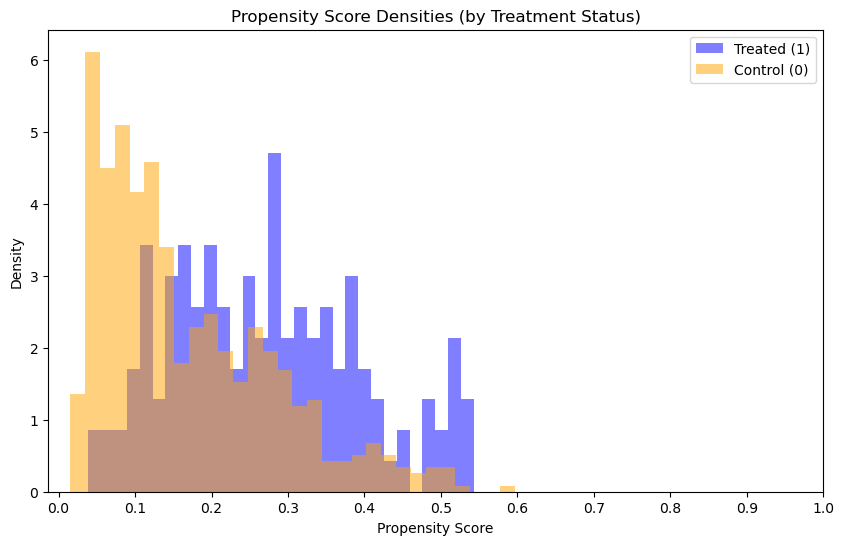

In [16]:
plot_propensity_scores(df, 'treat_binary', 'prop_score')

##### Basis expansion

In [17]:
"""
new_features = PolynomialFeatures(
    degree=2,
    interaction_only=False,
    include_bias=False
)
"""

'\nnew_features = PolynomialFeatures(\n    degree=2,\n    interaction_only=False,\n    include_bias=False\n)\n'

In [18]:
"""
preprocessor = ColumnTransformer(
    transformers=[
        ("pass", "passthrough", non_covariate_cols),
        ("augment", new_features, covariate_cols)
    ],
    verbose_feature_names_out=False
)
"""

'\npreprocessor = ColumnTransformer(\n    transformers=[\n        ("pass", "passthrough", non_covariate_cols),\n        ("augment", new_features, covariate_cols)\n    ],\n    verbose_feature_names_out=False\n)\n'

In [19]:
"""
df_augmented = preprocessor.fit_transform(df)
augmented_columns = preprocessor.get_feature_names_out()
df_augmented = pd.DataFrame(df_augmented, columns=augmented_columns)
df_augmented
"""

'\ndf_augmented = preprocessor.fit_transform(df)\naugmented_columns = preprocessor.get_feature_names_out()\ndf_augmented = pd.DataFrame(df_augmented, columns=augmented_columns)\ndf_augmented\n'

##### Synthetic into-treatment selection bias

In [151]:
strength = 1.5
selection_covariates = (df['x1'] + df['x2'] + df['x3'])
scores = expit(strength * selection_covariates)

In [152]:
df['treat_binary_bias'] = np.random.binomial(1, scores)

In [153]:
df['prop_score_bias'] = propensity_scores(df, covariate_cols, 'treat_binary_bias')

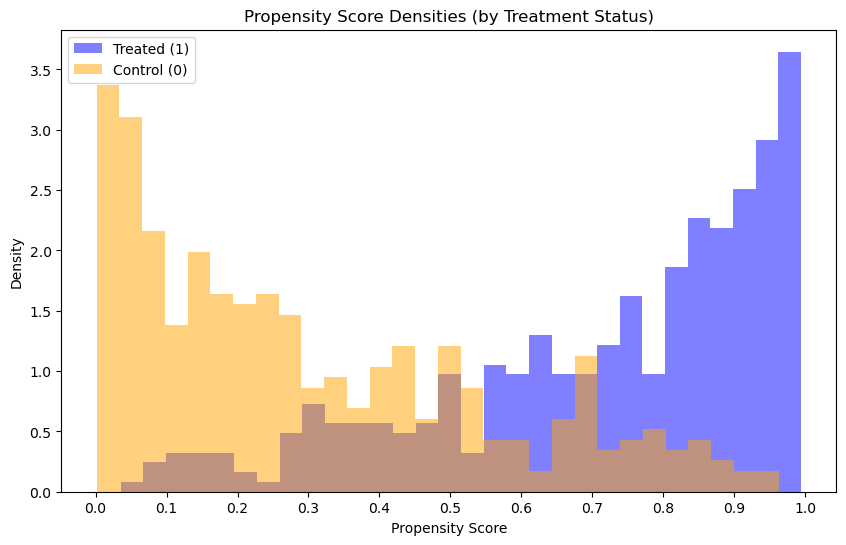

In [154]:
plot_propensity_scores(df, 'treat_binary_bias', 'prop_score_bias')

In [155]:
min(df['prop_score_bias']), max(df['prop_score_bias'])

In [156]:
df['observed_bias'] = np.where(df['treat_binary_bias'] == 1, df['cond_mean_treat'], df['cond_mean_control'])
df['counterfactual_bias'] = np.where(df['treat_binary_bias'] == 0, df['cond_mean_treat'], df['cond_mean_control'])

In [157]:
df = df[[
    "treat_binary",
    "prop_score",
    "observed",
    "counterfactual",
    "treat_binary_bias",
    "prop_score_bias",
    "observed_bias",
    "counterfactual_bias",
    "cond_mean_treat",
    "cond_mean_control",
    *covariate_cols
]]

In [158]:
df.head()

,treat_binary,prop_score,observed,counterfactual,treat_binary_bias,prop_score_bias,observed_bias,counterfactual_bias,cond_mean_treat,cond_mean_control,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,0.283505,5.599916,4.318780,1,0.764476,6.854457,3.268256,6.854457,3.268256,...,1,1,1,1,0,0,0,0,0,0
1,0,0.068051,6.875856,7.856495,0,0.006413,6.636059,7.562718,7.562718,6.636059,...,1,1,1,1,0,0,0,0,0,0
2,0,0.107717,2.996273,6.633952,0,0.154426,1.570536,6.121617,6.121617,1.570536,...,1,0,1,1,0,0,0,0,0,0
3,0,0.129523,1.366206,5.697239,0,0.362536,1.244738,5.889125,5.889125,1.244738,...,1,0,1,1,0,0,0,0,0,0
4,0,0.092541,1.963538,6.202582,0,0.132344,1.685048,6.191994,6.191994,1.685048,...,1,1,1,1,0,0,0,0,0,0


In [159]:
X_train = df.loc[df['treat_binary_bias']==0].copy()
X_test = df.loc[df['treat_binary_bias']==1].copy()
train_data = X_train.iloc[:,10:]
test_data = X_test.iloc[:,10:]

In [160]:
def check_balance(df_train, df_test):
    balance_results = []
    
    for col in train_data.columns:
        test_mean = df_test[col].mean()
        
        raw_train_mean = df_train[col].mean()
        
        std_pooled = np.sqrt((df_train[col].var() + df_test[col].var()) / 2)
        
        raw_smd = (raw_train_mean - test_mean) / std_pooled
        
        balance_results.append(raw_smd)
    
    return np.nanmean(np.abs(balance_results))

In [161]:
check_balance(train_data, test_data)

In [162]:
"""
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv, pinv
from scipy import stats
from sklearn.preprocessing import StandardScaler

X_train = df.loc[df['treat_binary_bias']==0].copy()
X_test = df.loc[df['treat_binary_bias']==1].copy()

scaler = StandardScaler()
train_data = scaler.fit_transform(X_train.iloc[:,10:])
test_data = scaler.transform(X_test.iloc[:,10:])

train_mean = train_data.mean(axis=0)
test_mean = test_data.mean(axis=0)

n1 = train_data.shape[0]
n2 = test_data.shape[0]
n_features = train_data.shape[1]  # Number of features (covariates)

S1 = np.cov(train_data.T, bias=False)
S2 = np.cov(test_data.T, bias=False)
Sp = ((n1 - 1)*S1 + (n2 - 1)*S2) / (n1 + n2 - 2)
cov_inv = pinv(Sp)

mahal_dist = mahalanobis(train_mean, test_mean, cov_inv)
#print(f"Mahalanobis distance unweighted: {mahal_dist:.4f}")

# Hotelling's T² statistic
T_sq = (n1 * n2) / (n1 + n2) * mahal_dist**2
#print(stats.chi2.sf(T_sq, df=n_features))

from scipy.stats import f

k = train_data.shape[1]

F_stat = ((n1 + n2 - k - 1) / (k * (n1 + n2 - 2))) * T_sq

df1 = k
df2 = n1 + n2 - k - 1

p_value = 1 - f.cdf(F_stat, df1, df2)

print("F statistic:", F_stat)
print("p-value:", p_value)

#p_val = stats.chi2.sf(mahal_dist**2, df=n_features)
#print(p_val)
"""

'\nfrom scipy.spatial.distance import mahalanobis\nfrom numpy.linalg import inv, pinv\nfrom scipy import stats\nfrom sklearn.preprocessing import StandardScaler\n\nX_train = df.loc[df[\'treat_binary_bias\']==0].copy()\nX_test = df.loc[df[\'treat_binary_bias\']==1].copy()\n\nscaler = StandardScaler()\ntrain_data = scaler.fit_transform(X_train.iloc[:,10:])\ntest_data = scaler.transform(X_test.iloc[:,10:])\n\ntrain_mean = train_data.mean(axis=0)\ntest_mean = test_data.mean(axis=0)\n\nn1 = train_data.shape[0]\nn2 = test_data.shape[0]\nn_features = train_data.shape[1]  # Number of features (covariates)\n\nS1 = np.cov(train_data.T, bias=False)\nS2 = np.cov(test_data.T, bias=False)\nSp = ((n1 - 1)*S1 + (n2 - 1)*S2) / (n1 + n2 - 2)\ncov_inv = pinv(Sp)\n\nmahal_dist = mahalanobis(train_mean, test_mean, cov_inv)\n#print(f"Mahalanobis distance unweighted: {mahal_dist:.4f}")\n\n# Hotelling\'s T² statistic\nT_sq = (n1 * n2) / (n1 + n2) * mahal_dist**2\n#print(stats.chi2.sf(T_sq, df=n_features))\n\n

---

In [ ]:
generator = SquaredGenerator(C=0.0).as_generator()
from genriesz import UKLGenerator, BKLGenerator
gen = BKLGenerator(C=1.0, branch_fn=lambda x: int(x[0] == 1)).as_generator()

result_ate = grr_ate(
    X=df.iloc[:, [4] + list(range(10, df.shape[1]))],                      # data including treatment
    Y=df['observed_bias'],                      # outcomes
    basis=PolynomialBasis(degree=1),              # basis function
    generator=generator,      # Bregman generator
    treatment_index=0,        # treatment is in column 0
    cross_fit=True,           # use cross-fitting for robustness
    folds=5,                  # 5-fold cross-fitting
    random_state=40,
)

print(result_ate.summary_text())

n=747, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  3.960939  (se=0.057180)  CI[95%]=3.848869,4.073010  p=0
   DM (shared):  3.967222  (se=0.000717)  CI[95%]=3.965818,3.968627  p=0
           IPW:  4.047568  (se=0.458141)  CI[95%]=3.149629,4.945508  p=0


In [64]:
result_ate.alpha_hat

array([ 4.65804854,  4.57726395, -1.59774472, -3.76633207,  0.36336452,
       -4.48986759, -0.25378549, -1.69181755, -0.16833736, -3.46446691,
        4.13550657, -3.34307853, -1.09440175, -2.1405605 , -4.87104945,
        3.55281263,  2.3695772 , -6.94761143, -3.69519893, -2.52270237,
       -1.55694266,  4.86239308,  0.58048736, -2.45647486,  4.20292035,
        3.97752859, -2.88278089,  0.67583481, -0.59054292,  1.91265283,
        0.75039193,  5.974957  ,  4.37522757,  1.01504017,  6.00156523,
        1.43639984,  2.46405166, -3.90300192, -0.65724811, -2.3209625 ,
        3.36821997, -0.02755372, -0.36910511,  1.36360711,  2.31598183,
        0.88745685,  2.34258658, -2.22843654,  3.23670953, -0.84095449,
       -1.88027297,  0.6529726 , -0.59046678, -2.4185758 ,  0.46205982,
       -6.89910147, -1.01220643,  0.05098009, -4.48053848,  5.04384343,
       -6.25637612,  1.93403867,  5.61842142,  0.99849445,  2.44281903,
       -3.09371389, -1.75117028,  1.78267306,  1.14642679,  4.22

In [177]:
from econml.dml import DML
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
import pandas as pd

est = DML(
    model_y=LassoCV(),             # Selects covariates for Y
    model_t=LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),# Selects covariates for T
    discrete_treatment=True,
    model_final=StatsModelsLinearRegression(fit_intercept=False),
)

# Fit
est.fit(df['observed_bias'], df['treat_binary_bias'], X=df.iloc[:, 10:])

# Average Treatment Effect
ate = est.ate(T0=0, T1=1, X=df.iloc[:, 10:])

print(ate)

3.9815420858147963


AttributeError: 'list' object has no attribute 'predict_proba'

In [186]:
X = df.iloc[:, list(range(10, df.shape[1]))]
D = df.iloc[:, 4]

log_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_model.fit(X, D)

# Extract coefficients
coefficients = log_model.coef_[0]  # Array of coefficients
intercept = log_model.intercept_[0]  # Intercept

In [187]:
e_hat = log_model.predict_proba(X)[:, 1]
weights = D / e_hat - (1 - D) / (1 - e_hat)

In [111]:
coefficients

array([ 4.38246333,  4.37960623,  4.25470988,  0.21965193, -0.0590516 ,
        0.        ,  0.        ,  0.        ,  0.18339335,  0.        ,
       -0.19696773,  0.        , -0.18542652,  0.21326261, -0.18028634,
        0.        , -0.19102903,  0.        ,  0.13181769,  0.        ,
        0.        , -0.4046381 ,  0.        ,  0.36258134, -0.06458614])

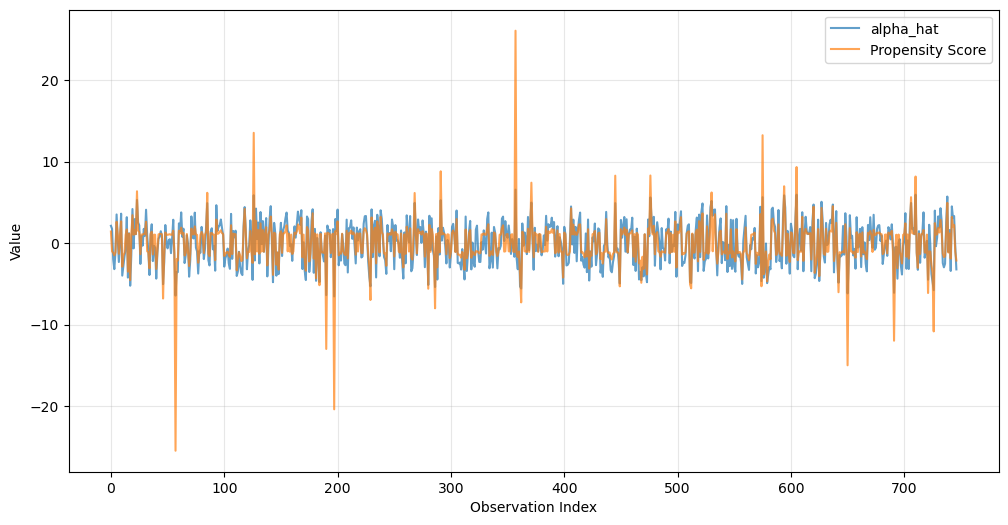

In [189]:
plt.figure(figsize=(12, 6))
plt.plot(result_ate.alpha_hat, label='alpha_hat', alpha=0.7)
plt.plot(weights, label='Propensity Score', alpha=0.7)
plt.xlabel('Observation Index')
plt.ylabel('alpha')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Justify DML over OLS under pursuit of ATE estimation in presence of selection bias and confounding.
# OLS measures ATT only under heteroskedastic treatment effects, DML measures ATE. OLS is biased in presence of selection bias and confounding, while DML is designed to account for these issues and provide unbiased estimates of ATE.

In [ ]:
"""
import requests
import pandas as pd

data_url = "https://www.economia.gob.mx/apidatamexico/tesseract/data.jsonrecords"

params = {
    "cube": "inegi_enoe",
    "drilldowns": str(','.join([
        "State",
        "Category", # Occupation
        "Sector",
        "Age Range",
        "Schooling Years Range",
        #"Second Job",
        "Instruction Level",

    ])),
    "measures": "Monthly Wage"
}

response = requests.get(data_url, params=params)
response.raise_for_status()  # will raise error if request fails
data_json = response.json()

# Convert JSON records into pandas DataFrame
df_data = pd.DataFrame(data_json["data"])

print("Data API result:")
print(df_data.head())
"""

Data API result:
   State ID           State  Category ID                       Category  \
0         1  Aguascalientes            1  Officers, Directors and Heads   
1         1  Aguascalientes            1  Officers, Directors and Heads   
2         1  Aguascalientes            1  Officers, Directors and Heads   
3         1  Aguascalientes            1  Officers, Directors and Heads   
4         1  Aguascalientes            1  Officers, Directors and Heads   

  Sector ID                                             Sector  Age Range ID  \
0        11  Agriculture, Animal Breeding and Production, F...             1   
1        11  Agriculture, Animal Breeding and Production, F...             1   
2        11  Agriculture, Animal Breeding and Production, F...             1   
3        11  Agriculture, Animal Breeding and Production, F...             2   
4        11  Agriculture, Animal Breeding and Production, F...             2   

        Age Range  Schooling Years Range ID        

In [ ]:
#df_data.shape

In [ ]:
#df_data.to_csv("mex_vizbuilder_employment.csv", index=False)

In [ ]:
# Training in past 3 months on current hours worked OR underemployment? APS